In [ ]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Dropout,SimpleRNN,LSTM,GRU
from keras.models import Sequential
from tensorflow import keras

In [ ]:
from google.colab import files
uploaded = files.upload()

# Prepare

In [ ]:
df = pd.read_csv('Bali 2015 - 2022.csv')
df = df[['datetime', 'total_accomodation', 'total_visitor']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   datetime            108 non-null    object
 1   total_accomodation  108 non-null    int64 
 2   total_visitor       108 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.7+ KB


In [ ]:
# datetime to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])
train_datetime = df['datetime']
df = df.set_index(['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2014-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   total_accomodation  108 non-null    int64
 1   total_visitor       108 non-null    int64
dtypes: int64(2)
memory usage: 2.5 KB


<Axes: xlabel='datetime'>

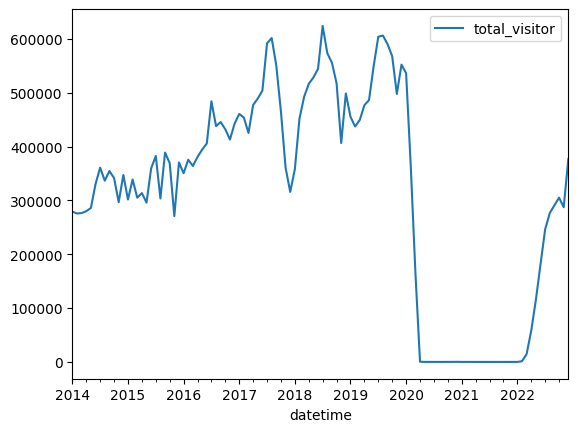

In [ ]:
df.iloc[:,1:].plot(legend=True)

In [ ]:
df.describe()

,total_accomodation,total_visitor
count,108.000000,108.000000
mean,36224.250000,314491.694444
std,11955.946508,197701.212263
min,16495.000000,0.000000
25%,26054.250000,178084.000000
50%,35928.000000,358883.500000
75%,46455.750000,461889.250000
max,58302.000000,624366.000000


In [ ]:
# standarisasi
features = ['total_visitor', 'total_accomodation']
ct = ColumnTransformer([
    ('Std', StandardScaler(), features)
    ], remainder='passthrough')
df[features] = ct.fit_transform(df[features])

In [ ]:
df.head()

,total_accomodation,total_visitor
datetime,,
2014-01-01,-1.657855,-0.179053
2014-02-01,-1.596849,-0.196646
2014-03-01,-1.587690,-0.192692
2014-04-01,-1.553490,-0.174789
2014-05-01,-1.461140,-0.144619


In [ ]:
# Window (?)
sequence_length = 18
d_tf = tf.keras.utils.timeseries_dataset_from_array(df.values, targets=df['total_visitor'].values, sequence_length=sequence_length)
X = []
y = []
for X_batch, y_batch in d_tf:
    X.append(X_batch.numpy())
    y.append(y_batch.numpy())
X = np.array(X)
y = np.array(y)

# 70:30

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X[0], y[0], test_size=0.3)

In [ ]:
# Model
model = Sequential()
model.add(SimpleRNN(512, activation="tanh", return_sequences=False, input_shape=(sequence_length, 2)))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 1024)              1051648   
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 1,052,673
Trainable params: 1,052,673
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer="adam",loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=100, batch_size=18, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
3/3 [==============================] - 2s 307ms/step - loss: 8.8840 - val_loss: 2.5745
Epoch 2/100
3/3 [==============================] - 0s 173ms/step - loss: 0.9174 - val_loss: 1.4255
Epoch 3/100
3/3 [==============================] - 0s 158ms/step - loss: 8.3172 - val_loss: 2.3503
Epoch 4/100
3/3 [==============================] - 0s 162ms/step - loss: 1.3745 - val_loss: 1.2682
Epoch 5/100
3/3 [==============================] - 0s 165ms/step - loss: 0.8020 - val_loss: 1.5752
Epoch 6/100
3/3 [==============================] - 1s 244ms/step - loss: 0.8532 - val_loss: 1.2679
Epoch 7/100
3/3 [==============================] - 1s 261ms/step - loss: 0.8458 - val_loss: 1.3823
Epoch 8/100
3/3 [==============================] - 1s 295ms/step - loss: 0.8461 - val_loss: 1.2201
Epoch 9/100
3/3 [==============================] - 1s 280ms/step - loss: 0.7728 - val_loss: 1.2717
Epoch 10/100
3/3 [==============================] - 1s 277ms/step - loss: 0.8367 - val_loss: 1.2337
Epoch 11/

In [ ]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 192ms/step


In [ ]:
print('R2 =', r2_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print('MAE: ', mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 = 0.29228950247638896
MSE:  0.5533261654167478
MAPE:  0.5872776708938706
MAE:  0.5557942036587746


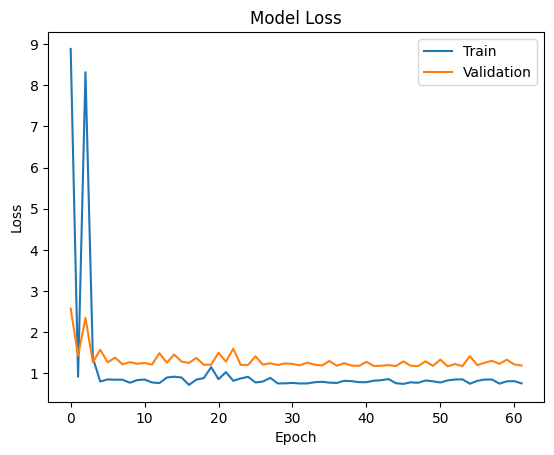

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

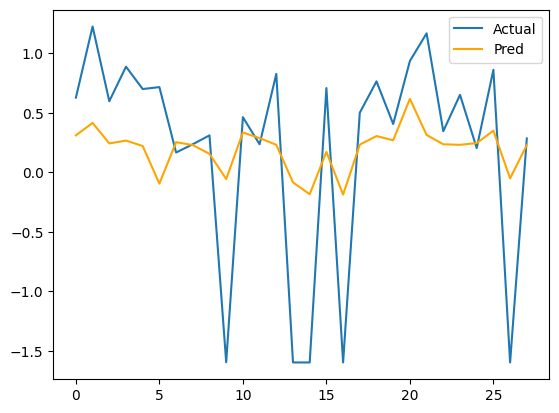

In [ ]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, color='orange', label='Pred')
plt.legend()

In [ ]:
# Forecasts
last_sequence = X[0][1]
forecasts = []
forecasts_period = 12

for _ in range(forecasts_period):
    input_sequence = last_sequence.reshape((1, sequence_length, 2))
    forecast = model.predict(input_sequence)
    forecasts.append(forecast[0, 0])

    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[-1, 0] = forecast[0, 0]

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Get the last datetime from the df index
last_date = df.index[-1]

# Define the time step based on daily data
time_step = relativedelta(months=1)

# Create a list of datetime objects starting from the last df date
datetimes = [last_date + i * time_step for i in range(1, forecasts_period + 1)]

# Convert the list to a datetime index
time_axis = pd.DatetimeIndex(datetimes)

# Create the DataFrame with datetime index
prediction_table = pd.DataFrame({'Time': time_axis, 'Predicted Value': forecasts})
prediction_table['Time'] = pd.to_datetime(prediction_table['Time'])
prediction_table = prediction_table.set_index(['Time'])

1/1 [==============================] - 0s 40ms/step


In [ ]:
# Buat lsit y_pred
'''pred = list(y_pred.reshape(y_pred.shape[0]))
for i in range(df.shape[0]-y_pred.shape[0]-sequence_length):
  pred.insert(0, None)
for i in range(sequence_length):
  pred.append( None)
df['RNN_70:30'] = pred'''

"pred = list(y_pred.reshape(y_pred.shape[0]))\nfor i in range(df.shape[0]-y_pred.shape[0]-sequence_length):\n  pred.insert(0, None)\nfor i in range(sequence_length):\n  pred.append( None)\ndf['RNN_70:30'] = pred"

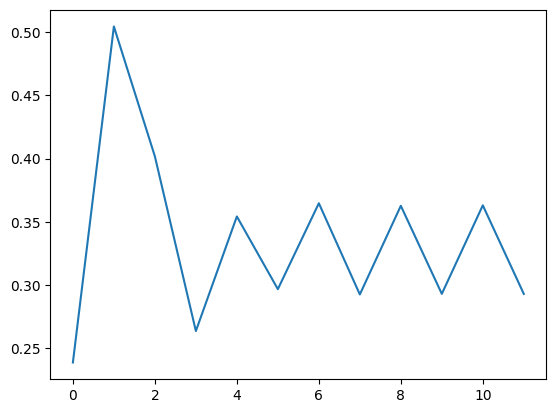

In [ ]:
plt.plot(forecasts)

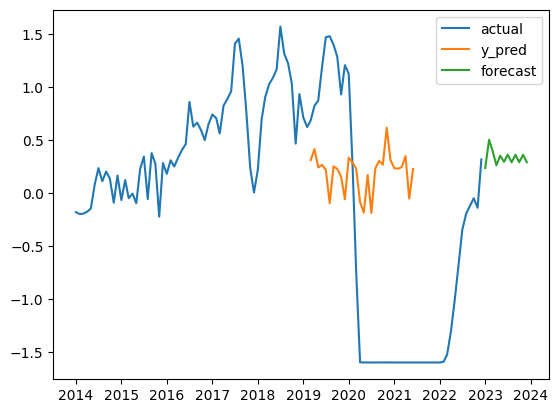

In [ ]:
plt.plot(df[['total_visitor']], label='actual')
plt.plot(df['RNN_70:30'], label='y_pred')
plt.plot(prediction_table['Predicted Value'], label='forecast')
plt.legend()

# 80:20

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X[0], y[0], test_size=0.2, shuffle=False)

In [ ]:
# Model
model = Sequential()
model.add(SimpleRNN(512, activation="tanh", return_sequences=False, input_shape=(sequence_length, 2)))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_104 (SimpleRNN)  (None, 512)               263680    
                                                                 
 dense_42 (Dense)            (None, 1)                 513       
                                                                 
Total params: 264,193
Trainable params: 264,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=100, batch_size=18, validation_split=0.2)

Epoch 1/100
4/4 [==============================] - 3s 185ms/step - loss: 2.1438 - val_loss: 0.8691
Epoch 2/100
4/4 [==============================] - 0s 80ms/step - loss: 0.2143 - val_loss: 0.8474
Epoch 3/100
4/4 [==============================] - 0s 60ms/step - loss: 0.0707 - val_loss: 0.4823
Epoch 4/100
4/4 [==============================] - 0s 71ms/step - loss: 0.0298 - val_loss: 0.4960
Epoch 5/100
4/4 [==============================] - 0s 74ms/step - loss: 0.0284 - val_loss: 0.2366
Epoch 6/100
4/4 [==============================] - 0s 84ms/step - loss: 0.0165 - val_loss: 0.3471
Epoch 7/100
4/4 [==============================] - 0s 75ms/step - loss: 0.0116 - val_loss: 0.3578
Epoch 8/100
4/4 [==============================] - 0s 79ms/step - loss: 0.0074 - val_loss: 0.2534
Epoch 9/100
4/4 [==============================] - 0s 109ms/step - loss: 0.0046 - val_loss: 0.3315
Epoch 10/100
4/4 [==============================] - 0s 70ms/step - loss: 0.0055 - val_loss: 0.2835
Epoch 11/100
4/4 

In [ ]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 176ms/step


In [ ]:
print('R2 =', r2_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print('MAE: ', mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 = 0.5998677751931862
MSE:  0.21141944232498053
MAPE:  0.2855688263290141
MAE:  0.4329933043847223


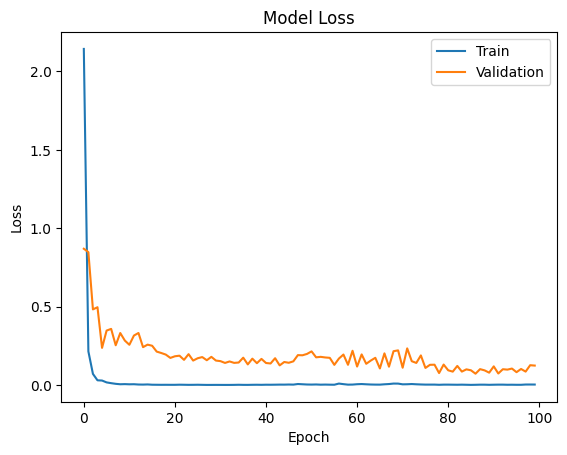

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

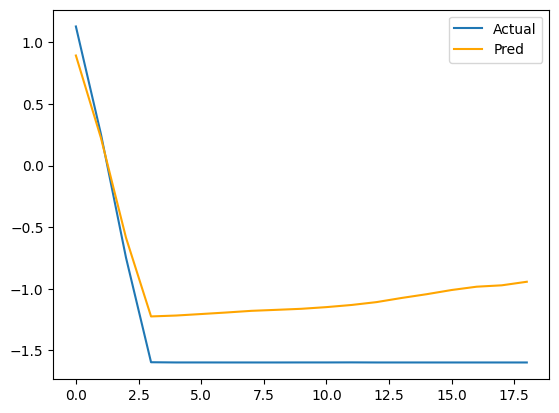

In [ ]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, color='orange', label='Pred')
plt.legend()

In [ ]:
# Forecasts
last_sequence = X[0][1]
forecasts = []
forecasts_period = 12

for _ in range(forecasts_period):
    input_sequence = last_sequence.reshape((1, sequence_length, 2))
    forecast = model.predict(input_sequence)
    forecasts.append(forecast[0, 0])

    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[-1, 0] = forecast[0, 0]

from datetime import datetime, timedelta

# Get the last datetime from the df index
last_date = df.index[-1]

# Define the time step based on daily data
time_step = relativedelta(months=1)

# Create a list of datetime objects starting from the last df date
datetimes = [last_date + i * time_step for i in range(1, forecasts_period + 1)]

# Convert the list to a datetime index
time_axis = pd.DatetimeIndex(datetimes)

# Create the DataFrame with datetime index
RNN8020_table = pd.DataFrame({'Time': time_axis, 'Predicted Value': forecasts})
RNN8020_table['Time'] = pd.to_datetime(RNN8020_table['Time'])
RNN8020_table = RNN8020_table.set_index(['Time'])

1/1 [==============================] - 0s 44ms/step


In [ ]:
# Buat lsit y_pred
pred = list(y_pred.reshape(y_pred.shape[0]))
for i in range(df.shape[0]-y_pred.shape[0]-sequence_length):
  pred.insert(0, None)
for i in range(sequence_length):
  pred.append( None)
df['RNN_80:20'] = pred

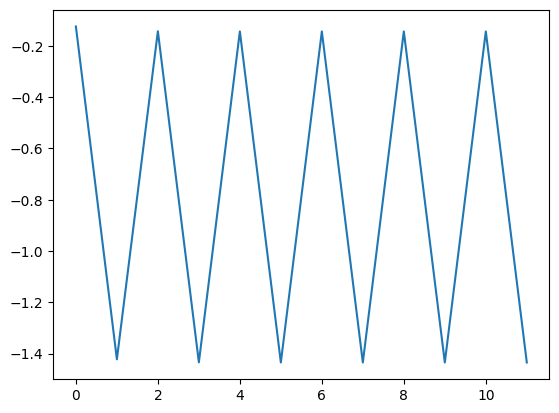

In [ ]:
plt.plot(forecasts)

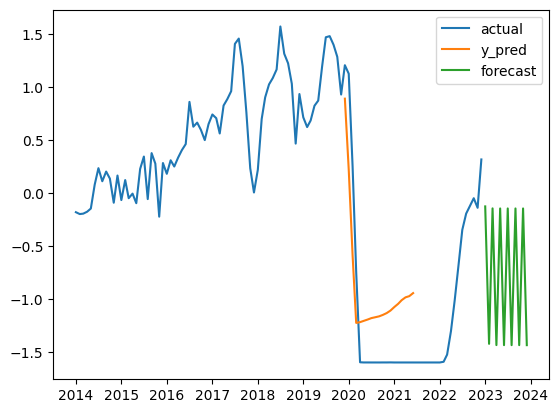

In [ ]:
plt.plot(df[['total_visitor']], label='actual')
plt.plot(df['RNN_80:20'], label='y_pred')
plt.plot(RNN8020_table['Predicted Value'], label='forecast')
plt.legend()